# Purposes of this document

even with the encoder, 
the decoder observation matrix weights converge to zero stably, not right. 
it should converge to encoder weights. 
we then examined the encoder firing rates, they are basically zeros. 

decoder's convergence to zero simply implies that firing rates are decorrelated from the encoded states.
by decorrelated, the firing rates are not encoding the states,  at least apparently. 


the main variables in this loop is 
1. to demonstrate signal to noise ratio has significant impact on the clda training quality
2. the signal to noise ratio is adjusting the encoder C matrix while keeping the noise cov matrix fixed. 
3. of course, this just intuitively makes sense: no matter how good our clda algorithm works, we need to have data to work with, the more meaningful (greater signal to noise ratio), the better the training. 


in the end, 
we will demonstrate the mismatch through
1. the rewarded trials and the reward trial rate. 
2. qualitative comparisions of trajectories. 
3. the tuning directions of C. and the tracking performance using correlation coefficients

# Experimental setup related to the questions

this part should be configured to directly test the hypothesis put forward in the previous section


In [1]:
import numpy as np

#encoder mean firing rate
neuron_firing_rates  = [100, 10, 1]

#for comparision
exp_conds = [f'enc. mean FR:{b} Hz' for b in neuron_firing_rates]


#setting clda parameters 
##learner: collects paird data at batch_sizes
RHO = 0.5
batch_size = 50


#assistor set up assist level
assist_level = (0.05, 0.0)

#learner and updater: actualy set up rho
UPDATER_BATCH_TIME = 1
UPDATER_HALF_LIFE = np.log(RHO)  * UPDATER_BATCH_TIME / np.log(0.5)


In [2]:
# CHANGE: game mechanics: generate task params
N_TARGETS = 8
N_TRIALS = 80

NUM_EXP = len(exp_conds) # how many experiments we are running. 

# setting up the simulation components

this section largely copyied and pasted from   
bmi3d-sijia(branch)-bulti_in_experiemnts
https://github.com/sijia66/brain-python-interface/blob/master/built_in_tasks/sim_task_KF.py

In [3]:
# import libraries
# make sure these directories are in the python path., 
from bmimultitasks import SimBMIControlMulti, SimBMICosEncKFDec, BMIControlMultiNoWindow
from features import SaveHDF
from features.simulation_features import get_enc_setup, SimKFDecoderRandom, SimCosineTunedEnc,SimIntentionLQRController, SimClockTick
from features.simulation_features import SimHDF, SimTime

from riglib import experiment

from riglib.stereo_opengl.window import FakeWindow
from riglib.bmi import train

from behaviour_metrics import calc_inter_wait_times,filter_state, sort_trials

from weights import replace_kalman_filter
import weights

import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import itertools #for identical sequences

np.set_printoptions(precision=2, suppress=True)


/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/blackrock/cerelink.py:13: UserWarning: Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system
  warnings.warn("Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system")


##  behaviour and task setup

In [4]:
seq = SimBMIControlMulti.sim_target_seq_generator_multi(
N_TARGETS, N_TRIALS)

#create a second version of the tasks
seqs = itertools.tee(seq, NUM_EXP + 1)
target_seq = list(seqs[NUM_EXP])

seqs = seqs[:NUM_EXP]


SAVE_HDF = False
SAVE_SIM_HDF = True #this makes the task data available as exp.task_data_hist
DEBUG_FEATURE = False


#base_class = SimBMIControlMulti
base_class = BMIControlMultiNoWindow

#for adding experimental features such as encoder, decoder
feats = []

## encoder

the cosine tuned encoder uses a poisson process, right
https://en.wikipedia.org/wiki/Poisson_distribution
so if the lambda is 1, then it's very likely 

In [5]:
ENCODER_TYPE = 'cosine_tuned_encoder'

#neuron set up : 'std (20 neurons)' or 'toy (4 neurons)' 
N_NEURONS, N_STATES, sim_C = get_enc_setup(sim_mode = 'toy')


#actually multiply out the firing rates. 
sim_C_all = [sim_C * nfr for nfr in neuron_firing_rates]


#set up intention feedbackcontroller
#this ideally set before the encoder
feats.append(SimIntentionLQRController)

#set up the encoder
if ENCODER_TYPE == 'cosine_tuned_encoder' :
    feats.append(SimCosineTunedEnc)
    print(f'{__name__}: selected SimCosineTunedEnc\n')

features.simulation_features: get_enc_setup has a tuning_level of 1 

__main__: selected SimCosineTunedEnc



## decoder setup

In [6]:
#clda on random 
DECODER_MODE = 'random' # random 

   #take care the decoder setup
if DECODER_MODE == 'random':
    feats.append(SimKFDecoderRandom)
    print(f'{__name__}: set base class ')
    print(f'{__name__}: selected SimKFDecoderRandom \n')
else: #defaul to a cosEnc and a pre-traind KF DEC
    from features.simulation_features import SimKFDecoderSup
    feats.append(SimKFDecoderSup)
    print(f'{__name__}: set decoder to SimKFDecoderSup\n')

__main__: set base class 
__main__: selected SimKFDecoderRandom 



##  clda: learner and updater

In [7]:


LEARNER_TYPE = 'feedback' # to dumb or not dumb it is a question 'feedback'
UPDATER_TYPE = 'smooth_batch' #none or "smooth_batch"


#you know what? 
#learner only collects firing rates labeled with estimated estimates
#we would also need to use the labeled data
#now, we can set up a dumb/or not-dumb learner
if LEARNER_TYPE == 'feedback':
    from features.simulation_features import SimFeedbackLearner
    feats.append(SimFeedbackLearner)
else:
    from features.simulation_features import SimDumbLearner
    feats.append(SimDumbLearner)

#to update the decoder.
if UPDATER_TYPE == 'smooth_batch':
    from features.simulation_features import SimSmoothBatch
    feats.append(SimSmoothBatch)
else: #defaut to none 
    print(f'{__name__}: need to specify an updater')
    



## assistor setup

## (Check) config the experiment

In [8]:
if DEBUG_FEATURE: 
    from features.simulation_features import DebugFeature
    feats.append(DebugFeature)
    
if SAVE_HDF: feats.append(SaveHDF)
if SAVE_SIM_HDF: feats.append(SimHDF)
    
    
#pass the real time limit on clock
feats.append(SimClockTick)
feats.append(SimTime)


kwargs_exps = list()

for i in range(NUM_EXP):
    d = dict()
    
    d['assist_level'] = assist_level
    d['sim_C'] = sim_C_all[i]
    d['batch_size'] = batch_size
    
    d['batch_time'] = UPDATER_BATCH_TIME
    d['half_life'] = UPDATER_HALF_LIFE
    
    kwargs_exps.append(d)


kwargs_exps

[{'assist_level': (0.05, 0.0),
  'sim_C': array([[   0.,    0.,    0.,  100.,    0.,    0.,    0.],
         [   0.,    0.,    0., -100.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,  100.,    0.],
         [   0.,    0.,    0.,    0.,    0., -100.,    0.]]),
  'batch_size': 50,
  'batch_time': 1,
  'half_life': 1.0},
 {'assist_level': (0.05, 0.0),
  'sim_C': array([[  0.,   0.,   0.,  10.,   0.,   0.,   0.],
         [  0.,   0.,   0., -10.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,  10.,   0.],
         [  0.,   0.,   0.,   0.,   0., -10.,   0.]]),
  'batch_size': 50,
  'batch_time': 1,
  'half_life': 1.0},
 {'assist_level': (0.05, 0.0),
  'sim_C': array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
         [ 0.,  0.,  0., -1.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  1.,  0.],
         [ 0.,  0.,  0.,  0.,  0., -1.,  0.]]),
  'batch_size': 50,
  'batch_time': 1,
  'half_life': 1.0}]

## make and initalize experiment instances

In [9]:
#seed the experiment
np.random.seed(0)

#spawn the task
Exp = experiment.make(base_class, feats=feats)

exps = list()#create a list of experiment

for i,s in enumerate(seqs):
    e = Exp(s, **kwargs_exps[i])
    exps.append(e)

#run the ini
for e in exps: e.init()

metaclass constructor
(<class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEnc'>, <class 'features.simulation_features.SimKFDecoderRandom'>, <class 'features.simulation_features.SimFeedbackLearner'>, <class 'features.simulation_features.SimSmoothBatch'>, <class 'features.simulation_features.SimHDF'>, <class 'features.simulation_features.SimClockTick'>, <class 'features.simulation_features.SimTime'>, <class 'bmimultitasks.BMIControlMultiNoWindow'>)
[<class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEnc'>, <class 'features.simulation_features.SimKFDecoderRandom'>, <class 'features.simulation_features.SimFeedbackLearner'>, <class 'features.simulation_features.SimSmoothBatch'>, <class 'features.simulation_features.SimHDF'>, <class 'features.simulation_features.SimClockTick'>, <class 'features.simulation_features.SimTime'>]

features.simulation_features.SimInte

# Pre-experiment check: check the Kalman filter before training

we replace the encoder using the weights
assume, they are all randomly initialized get the first decoder
get a handle to the first decoder
we check the new decoder C matrix:


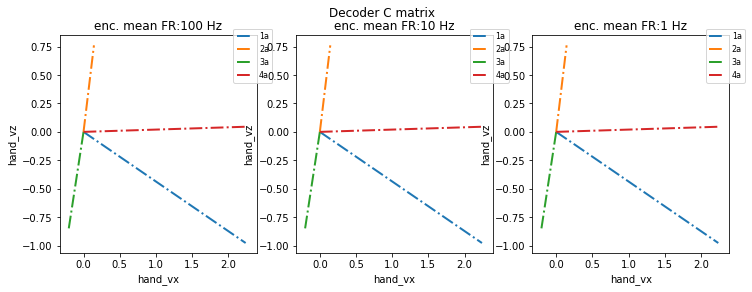

In [10]:
print('we replace the encoder using the weights')
print('assume, they are all randomly initialized get the first decoder')
print('get a handle to the first decoder')
first_decoder = exps[0].decoder
target_C = first_decoder.filt.C
    
#replace the decoder
for i,e in enumerate(exps):
    weights.replace_kalman_filter(e.decoder.filt, target_C, debug=False)
    
print('we check the new decoder C matrix:')

decoder_c_figure, axs = plt.subplots(nrows=1, 
                               ncols=NUM_EXP, figsize = [12,4])
decoder_c_figure.suptitle('Decoder C matrix ')

for i,e in enumerate(exps):
    e.decoder.plot_C(ax = axs[i])
    axs[i].set_title(exp_conds[i])

# Experiment run: assemble into a complete loop

##  define the function

In [11]:
#make this into a loop

def run_exp_loop(exp,  **kwargs):
        # riglib.experiment: line 597 - 601
    #exp.next_trial = next(exp.gen)
    # -+exp._parse_next_trial()np.arraynp.array


    # we need to set the initial state
    # per fsm.run:  line 138


    # Initialize the FSM before the loop
    exp.set_state(exp.state)
    
    finished_trials = exp.calc_state_occurrences('wait')
    print(f'finished: {finished_trials}')


    while exp.state is not None:

        # exp.fsm_tick()

        ### Execute commands#####
        exp.exec_state_specific_actions(exp.state)

        ###run the bmi loop #####
        # _cycle

        # bmi feature extraction, eh
        #riglib.bmi: 1202
        feature_data = exp.get_features()

        # Determine the target_state and save to file
        current_assist_level = exp.get_current_assist_level()
        target_state = exp.get_target_BMI_state(exp.decoder.states)

        # Determine the assistive control inputs to the Decoder
        #update assistive control level
        exp.update_level()
        if np.any(current_assist_level) > 0:
            current_state = exp.get_current_state()

            if target_state.shape[1] > 1:
                assist_kwargs = exp.assister(current_state, 
                                             target_state[:,0].reshape(-1,1), 
                                             current_assist_level, mode= exp.state)
            else:
                assist_kwargs = exp.assister(current_state, 
                                              target_state, 
                                              current_assist_level, 
                                              mode= exp.state)

            kwargs.update(assist_kwargs)
            
        

        # decode the new features
        # riglib.bmi.bmiloop: line 1245
        neural_features = feature_data[exp.extractor.feature_type]

        # call decoder.
        #tmp = exp.call_decoder(neural_features, target_state, **kwargs)
        neural_obs = neural_features
        learn_flag = exp.learn_flag
        task_state = exp.state

        n_units, n_obs = neural_obs.shape
        # If the target is specified as a 1D position, tile to match
        # the number of dimensions as the neural features
        if np.ndim(target_state) == 1 or (target_state.shape[1] == 1 and n_obs > 1):
            target_state = np.tile(target_state, [1, n_obs])

        decoded_states = np.zeros([exp.bmi_system.decoder.n_states, n_obs])
        update_flag = False

        for k in range(n_obs):
            neural_obs_k = neural_obs[:, k].reshape(-1, 1)
            target_state_k = target_state[:, k]

            # NOTE: the conditional below is *only* for compatibility with older Carmena
            # lab data collected using a different MATLAB-based system. In all python cases,
            # the task_state should never contain NaN values.
            if np.any(np.isnan(target_state_k)):
                task_state = 'no_target'

            #################################
            # Decode the current observation
            #################################
            decodable_obs, decode = exp.bmi_system.feature_accumulator(
                neural_obs_k)
            if decode:  # if a new decodable observation is available from the feature accumulator
                prev_state = exp.bmi_system.decoder.get_state()

                exp.bmi_system.decoder(decodable_obs, **kwargs)
                # Determine whether the current state or previous state should be given to the learner
                if exp.bmi_system.learner.input_state_index == 0:
                    learner_state = exp.bmi_system.decoder.get_state()
                elif exp.bmi_system.learner.input_state_index == -1:
                    learner_state = prev_state
                else:
                    print(("Not implemented yet: %d" %
                           exp.bmi_system.learner.input_state_index))
                    learner_state = prev_state

                if learn_flag:
                    exp.bmi_system.learner(decodable_obs.copy(), learner_state, target_state_k, exp.bmi_system.decoder.get_state(
                    ), task_state, state_order=exp.bmi_system.decoder.ssm.state_order)

            decoded_states[:, k] = exp.bmi_system.decoder.get_state()

            ############################
            # Update decoder parameters
            ############################
            if exp.bmi_system.learner.is_ready():
                batch_data = exp.bmi_system.learner.get_batch()
                batch_data['decoder'] = exp.bmi_system.decoder
                kwargs.update(batch_data)
                exp.bmi_system.updater(**kwargs)
                exp.bmi_system.learner.disable()
                

            new_params = None  # by default, no new parameters are available
            if exp.bmi_system.has_updater:
                new_params = copy.deepcopy(exp.bmi_system.updater.get_result())
                
            
            # Update the decoder if new parameters are available
            if not (new_params is None):
                exp.bmi_system.decoder.update_params(
                    new_params, **exp.bmi_system.updater.update_kwargs)
                new_params['intended_kin'] = batch_data['intended_kin']
                new_params['spike_counts_batch'] = batch_data['spike_counts']

                exp.bmi_system.learner.enable()
                update_flag = True

                # Save new parameters to parameter history
                exp.bmi_system.param_hist.append(new_params)



        # saved as task data
        # return decoded_states, update_flag
        tmp = decoded_states
        exp.task_data['internal_decoder_state'] = tmp

        # reset the plant position
        # @riglib.bmi.BMILoop.move_plant  line:1254
        exp.plant.drive(exp.decoder)

        # check state transitions and run the FSM.
        current_state = exp.state

        # iterate over the possible events which could move the task out of the current state
        for event in exp.status[current_state]:
            # if the event has occurred
            if exp.test_state_transition_event(event):
                # execute commands to end the current state
                exp.end_state(current_state)

                # trigger the transition for the event
                exp.trigger_event(event)

                # stop searching for transition events (transition events must be
                # mutually exclusive for this FSM to function properly)
                break

        # sort out the loop params.
        # inc cycle count
        exp.cycle_count += 1

        # save target data as was done in manualControlTasks._cycle
        exp.task_data['target'] = exp.target_location.copy()
        exp.task_data['target_index'] = exp.target_index

        #done in bmi:_cycle after move_plant
        exp.task_data['loop_time'] = exp.iter_time()


        #fb_controller data
        exp.task_data['target_state'] = target_state

        #encoder data
        #input to this is actually extractor
        exp.task_data['ctrl_input'] = np.reshape(exp.extractor.sim_ctrl, (1,-1))

        #actually output
        exp.task_data['spike_counts'] = feature_data['spike_counts']


        #save the decoder_state
        #from BMILoop.move_plant
        exp.task_data['decoder_state'] = exp.decoder.get_state(shape=(-1,1))
        
        #save bmi_data
        exp.task_data['update_bmi'] = update_flag


        # as well as plant data.
        plant_data = exp.plant.get_data_to_save()
        for key in plant_data:
            exp.task_data[key] = plant_data[key]

        # clda data handled in the above call.

        # save to the list hisory of data.
        exp.task_data_hist.append(exp.task_data.copy())
        
        #print out the trial update whenever wait count changes, alright. 
        if finished_trials != exp.calc_state_occurrences('wait'):
            finished_trials = exp.calc_state_occurrences('wait')
            print(f'finished trials :{finished_trials} with a current assist level of {exp.get_current_assist_level()}')
        

    if exp.verbose:
        print("end of FSM.run, task state is", exp.state)
    
    


## actually running the experiments

In [12]:
for i,e in enumerate(exps):
    run_exp_loop(e, **kwargs_exps[i])
    print(f'Finished running  {exp_conds[i]}')
    print()

runseq
finished: 1
assist_level:  0.05


/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/bmi/kfdecoder.py:372: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C = np.mat(np.linalg.lstsq(X.T, Y.T)[0].T)


finished trials :2 with a current assist level of 0.04881527777777778
finished trials :3 with a current assist level of 0.04863194444444445
finished trials :4 with a current assist level of 0.048440277777777783
finished trials :5 with a current assist level of 0.048238888888888894
finished trials :6 with a current assist level of 0.048023611111111114
finished trials :7 with a current assist level of 0.04781527777777778
finished trials :8 with a current assist level of 0.04761388888888889
finished trials :9 with a current assist level of 0.04740555555555556
finished trials :10 with a current assist level of 0.04720694444444445
finished trials :11 with a current assist level of 0.046998611111111116
finished trials :12 with a current assist level of 0.046783333333333336
finished trials :13 with a current assist level of 0.046575000000000005
finished trials :14 with a current assist level of 0.04636666666666667
finished trials :15 with a current assist level of 0.046158333333333336
finishe

finished trials :37 with a current assist level of 0.03724027777777778
finished trials :38 with a current assist level of 0.03703194444444445
finished trials :39 with a current assist level of 0.03674722222222222
finished trials :40 with a current assist level of 0.03645555555555556
finished trials :41 with a current assist level of 0.03623194444444445
finished trials :42 with a current assist level of 0.03598194444444445
finished trials :43 with a current assist level of 0.03574027777777778
finished trials :44 with a current assist level of 0.03539861111111112
assist_level:  0.035
finished trials :45 with a current assist level of 0.03466388888888889
finished trials :46 with a current assist level of 0.03433055555555556
finished trials :47 with a current assist level of 0.03399722222222222
finished trials :48 with a current assist level of 0.033663888888888896
finished trials :49 with a current assist level of 0.033424999999999996
finished trials :50 with a current assist level of 0.0

finished trials :68 with a current assist level of 0.0
finished trials :69 with a current assist level of 0.0
finished trials :70 with a current assist level of 0.0
finished trials :71 with a current assist level of 0.0
finished trials :72 with a current assist level of 0.0
finished trials :73 with a current assist level of 0.0
finished trials :74 with a current assist level of 0.0
finished trials :75 with a current assist level of 0.0
finished trials :76 with a current assist level of 0.0
finished trials :77 with a current assist level of 0.0
finished trials :78 with a current assist level of 0.0
finished trials :79 with a current assist level of 0.0
finished trials :80 with a current assist level of 0.0
finished trials :81 with a current assist level of 0.0
end of FSM.run, task state is None
Finished running  enc. mean FR:1 Hz



# Postprocessing the data for loading

In [13]:
for e in  exps: print(e.calc_state_occurrences('reward'))

80
80
79


## declare defs and conventions

In [14]:
FRAME_RATE = 60
INT_WINDOW_TIME = 10 # s for looking at sample raw data

# some conventions as we go down the loop
X_VEL_STATE_IND = 3
Y_VEL_STATE_IND = 5
X_POS_STATE_IND = 0
Y_POS_STATE_IND = 2

state_indices = [X_POS_STATE_IND,
                 Y_POS_STATE_IND,
                 X_VEL_STATE_IND,
                 Y_VEL_STATE_IND]
state_names = ['x pos ', 'y pos', 'x vel', 'y vel']


INT_WIN_SAMPLES = INT_WINDOW_TIME * FRAME_RATE



## Refactor out the data

In [15]:
task_data_hist_np_all = [np.array(e.task_data_hist) for e in exps]
task_data_hist_np_all[0].dtype

dtype([('cursor', '<f8', (3,)), ('obs_t', '<f8', (4, 1)), ('K', '<f8', (7, 4)), ('KC', '<f8', (7, 7)), ('pred_state_mean', '<f8', (7, 1)), ('post_state_mean', '<f8', (7, 1)), ('pred_state_P', '<f8', (7, 7)), ('post_state_P', '<f8', (7, 7)), ('loop_time', '<f8', (1,)), ('decoder_state', '<f8', (7, 1)), ('internal_decoder_state', '<f8', (7, 1)), ('target_state', '<f8', (7, 1)), ('update_bmi', '<f8', (1,)), ('spike_counts', '<f8', (4, 1)), ('bin_edges', '<f8', (2,)), ('ctrl_input', '<f8', (7,)), ('assist_level', '<f8', (1,)), ('target', '<f8', (3,)), ('target_index', '<i4', (1,))])

In [67]:
finished_times_in_seconds = [int(len(s)/FRAME_RATE) for s in task_data_hist_np_all]

finished_times_in_seconds

[237, 307, 792]

# Post data analysis

## Overall  trial statistics succuss rate)

In [16]:
state_logs = [e.state_log for e in exps]


In [17]:
STATE_CUT_NAME =  'wait'
#get the state logs
wait_logs = [filter_state(s, STATE_CUT_NAME) for s in state_logs]

inter_wait_times = [calc_inter_wait_times(w) for w in wait_logs]
#this has both start times 

Text(0, 0.5, 'Trial time (s)')

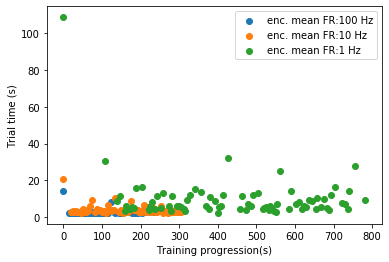

In [18]:


for i in inter_wait_times:
    plt.scatter(i[:,0], i[:,1])

plt.legend(exp_conds)
plt.xlabel('Training progression(s)')
plt.ylabel('Trial time (s)')

In [19]:
wait_time = inter_wait_times[0]
task_data_hist_np = task_data_hist_np_all[0]



In [21]:


trial_dicts_all = []
dict_keys = ['cursor', #behaviour
             'ctrl_input', 'spike_counts', #encoder translates intended ctrl into spike counts
             'decoder_state']

for i in range(NUM_EXP):
    wait_time = inter_wait_times[i]
    task_data_hist_np = task_data_hist_np_all[i]
    
    trial_dict_0 = sort_trials(wait_time, 
                               target_seq,
                               task_data_hist_np, dict_keys)
    
    trial_dicts_all.append(trial_dict_0)



3

In [59]:
print('finished times')

trial_dicts_all[0]

finished times


[{'cursor': array([[0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  ],
         ...,
         [8.59, 0.  , 0.72],
         [8.46, 0.  , 0.46],
         [8.46, 0.  , 0.46]]),
  'ctrl_input': array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
         [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
         [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
         ...,
         [ 8.48,  0.  ,  0.46, ...,  0.  , -1.95,  1.  ],
         [ 8.48,  0.  ,  0.46, ...,  0.  , -1.95,  1.  ],
         [ 8.28,  0.  ,  0.23, ...,  0.  , -1.53,  1.  ]]),
  'spike_counts': array([[ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0., 11.,  0., 14.]]),
  'decoder_state': array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
         [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
         [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  1.  ],
         ...,

## Trajectory analysis

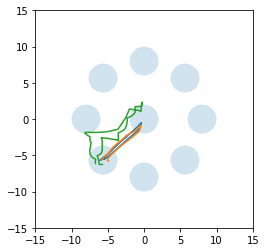

In [22]:
n_roi_trials = N_TRIALS - 1
unique_targets =  np.unique(target_seq, axis = 0)


X_CURSOR = 0
Z_CURSOR = 2
CIRCL_ALPHA = 0.2



RANGE_LIM =  15
figure, axes = plt.subplots() 

axes.set_xlim(-RANGE_LIM, RANGE_LIM)
axes.set_ylim(-RANGE_LIM, RANGE_LIM)

CIRCLE_RADIUS = exps[0].target_radius

#plot the targets

#plot the origin

cc = plt.Circle((0,0 ), 
            radius = CIRCLE_RADIUS,
            alpha = CIRCL_ALPHA)

axes.add_artist( cc ) 

for origin_t in unique_targets:
    origin = origin_t[0]
    t = origin_t[1]

    cc = plt.Circle((t[X_CURSOR],t[Z_CURSOR] ), 
                    radius = CIRCLE_RADIUS,
                    alpha = CIRCL_ALPHA)
                     
    axes.set_aspect( 1 ) 
    axes.add_artist( cc ) 
    
    
for trial_dict in trial_dicts_all:
    
    sample_trial = trial_dict[n_roi_trials]
    trial_cursor_trajectory = sample_trial['cursor']
    
    
    axes.plot(trial_cursor_trajectory[:, X_CURSOR], 
             trial_cursor_trajectory[:, Z_CURSOR])
    N_TRIALS = 80



In [23]:
print('finished trials:')

for i,e in  enumerate(exps): 
    reward_num = e.calc_state_occurrences('reward')
    print(f'{exp_conds[i]}: {reward_num} out of {N_TRIALS}')

finished trials:
enc. mean FR:100 Hz: 80 out of 80
enc. mean FR:10 Hz: 80 out of 80
enc. mean FR:1 Hz: 79 out of 80


## encoder

the job of the encoder is to directly encode intention into firing rates
the direct measure is just pearson correlation coefficients between 
the intentions and the firing rates

In [24]:
print('the encoder observation Q matrix')
for i,e in enumerate(exps):
    print(exp_conds[i])
    print(e.encoder.ssm.w)

the encoder observation Q matrix
enc. mean FR:100 Hz
7
enc. mean FR:10 Hz
7
enc. mean FR:1 Hz
7


In [25]:
n_exp = 0


spike_count_sample = trial_dicts_all[n_exp][n_roi_trials]['spike_counts']

## decoder

steady state tuning curves:


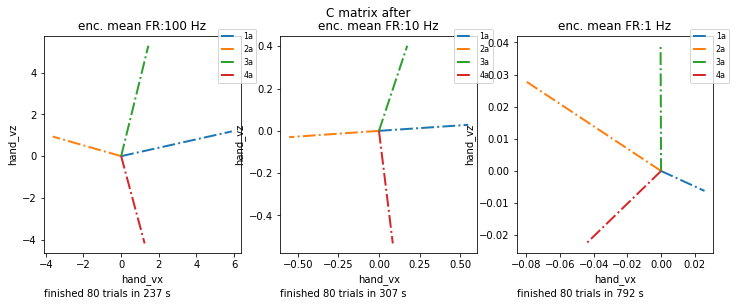

In [81]:

TEXT_OFFSET_VERTICAL = -0.2

decoder_c_after,axs = plt.subplots(1, NUM_EXP,
                                  figsize = (12,4))

decoder_c_after.suptitle('C matrix after')

print('steady state tuning curves:')
for i,e in enumerate(exps):
    e.decoder.plot_C(ax = axs[i])
    axs[i].set_title(exp_conds[i])
    
    #get the lower left coordinate
    y_lim_range  = axs[i].get_ylim()[1] - axs[i].get_ylim()[0]
    
    axs[i].text(0, TEXT_OFFSET_VERTICAL,
                f'finished {N_TRIALS} trials in {finished_times_in_seconds[i]} s', 
               transform = axs[i].transAxes)

    



compare to before


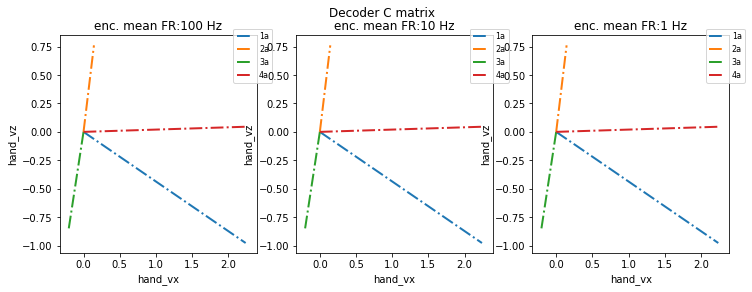

In [38]:
print('compare to before')

decoder_c_figure

# CLDA updates

## clda update frequencies

In [27]:

clda_params_all = [np.array(e.bmi_system.param_hist) for e in exps]

for c in clda_params_all:
    print(f'did clda for {len(c)} times')

did clda for 47 times
did clda for 61 times
did clda for 158 times


In [28]:
update_bmi_all = np.squeeze(task_data_hist_np_all[0]['update_bmi'])

Text(0.5, 0, 'frame count')

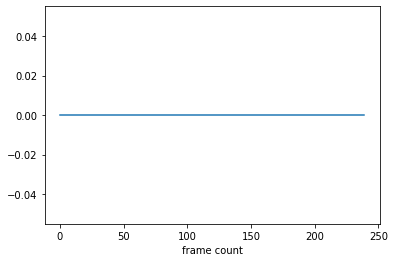

In [29]:
plt.plot(update_bmi_all[:240])
plt.xlabel('frame count')

## reformat the matrix

In [30]:
clda_params = clda_params_all[0]

clda_params_dict_all = list()

for p in clda_params_all:
    clda_params_dict = dict()
    for param_key in p[0].keys():
        clda_params_dict[param_key] = np.array([ record_i[param_key] for record_i in p])
    
    clda_params_dict_all.append(clda_params_dict)


len(clda_params_dict_all)

3

## observation covariance matrix

In [31]:
n_sample = 1

for i,c in enumerate(clda_params_dict_all):
    print(exp_conds[i])
    print(c['kf.Q'][n_sample,:,:])
    print()

enc. mean FR:100 Hz
[[ 716.09  609.91  174.27  188.76]
 [ 609.91  625.69  171.39  184.52]
 [ 174.27  171.39 1090.04  924.63]
 [ 188.76  184.52  924.63  960.16]]

enc. mean FR:10 Hz
[[ 6.09  0.    0.32 -0.  ]
 [ 0.    2.5   0.    0.  ]
 [ 0.32  0.    7.28  0.01]
 [-0.    0.    0.01  2.5 ]]

enc. mean FR:1 Hz
[[ 2.87  0.   -0.05  0.  ]
 [ 0.    2.5   0.    0.  ]
 [-0.05  0.    2.96  0.  ]
 [ 0.    0.    0.    2.5 ]]



## clda K matrix

In [32]:
kf_C = clda_params_dict['kf.C']

In [33]:
print('K matrix before:')
print(kf_C[0,:,:])
print('K matrix after:')
print(kf_C[-1,:,:])

K matrix before:
[[ 0.    0.    0.    1.16  0.   -0.45  0.48]
 [ 0.    0.    0.    0.07  0.    0.38  0.06]
 [ 0.    0.    0.   -0.11  0.   -0.36 -1.27]
 [ 0.    0.    0.    1.13  0.    0.02 -0.09]]
K matrix after:
[[ 0.    0.    0.    0.03  0.   -0.01  0.08]
 [ 0.    0.    0.   -0.08  0.    0.03  0.18]
 [ 0.    0.    0.   -0.    0.    0.04  0.1 ]
 [ 0.    0.    0.   -0.04  0.   -0.02  0.16]]


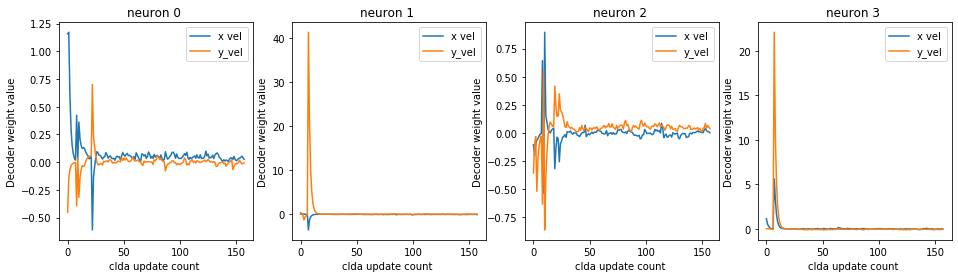

In [34]:
N_CLDA_ROI_TIME = 800

FIGURE_SIZE = (2,10)

N_NEURONS

f, axs = plt.subplots(1,N_NEURONS,figsize=(16,4))

for i in range(N_NEURONS):
    axs[i].plot(np.squeeze(kf_C[:N_CLDA_ROI_TIME,i, X_VEL_STATE_IND]))
    axs[i].plot(np.squeeze(kf_C[:N_CLDA_ROI_TIME,i, Y_VEL_STATE_IND]))
    axs[i].legend(['x vel', 'y_vel'])
    axs[i].set_title(f'neuron {i} ')
    axs[i].set_xlabel('clda update count ')
    axs[i].set_ylabel('Decoder weight value')



In [35]:
exps[0].encoder.C

array([[   0.,    0.,    0.,  100.,    0.,    0.,    0.],
       [   0.,    0.,    0., -100.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,  100.,    0.],
       [   0.,    0.,    0.,    0.,    0., -100.,    0.]])

## examine training batches

In [36]:
spike_counts_batch = clda_params_dict['spike_counts_batch'] 
intended_kin = clda_params_dict['intended_kin']

In [37]:
training_sample_point = 2

print('intended kinematics:')
print(intended_kin[training_sample_point])

print('spike counts:')
print(spike_counts_batch[training_sample_point])

print('trained KF C matrix:')
print(kf_C[training_sample_point])

intended kinematics:
[[  1.46   1.62   1.83   2.09   2.35   2.61   2.84   3.08   3.32   3.52
    3.62   3.79   3.97   4.23   4.37   4.51   4.66   4.8    4.97   5.16
    5.33   5.49   5.62   5.77   5.94   6.1    6.25   6.4    6.53   6.68
    6.83   6.96   7.11   7.26   7.44   7.61   7.79   7.92   8.1    8.26
    8.44   8.59   8.75   8.91   9.04   9.2    9.33   9.51   9.6    9.73]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.  ]
 [-10.41 -10.87 -11.04 -11.25 -11.46 -11.67 -12.08 -12.41 -12.74 -12.91
  -13.7  -14.01 -14.   -14.   -14.   -14.   -14.   -14.   -14.   -13.91
  -13.92 -14.   -14.   -14.   -14.   -14.   -14.   -14.   -14.   -14.
  -14.   -14.   -14.   -14.   -13.91 -14.02 -13.84 